# CHELSA 2010 Mean Temperature and Precipitation

In [1]:
import rioxarray as rio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
sample_pr = "/home/tkhan/biodt/storage/finetune/chelsa/pr_raw/CHELSA_pr_02_2010_V.2.1.tif"
sample_tas = "/home/tkhan/biodt/storage/finetune/chelsa/tas_raw/CHELSA_tas_02_2010_V.2.1.tif"

# Define Grid: Defines a lat/lon bounding box over Europe/North Africa/West Asia | Creates grid bins every 0.25° for later grouping.
LAT_START, LAT_END = 32.0, 72.0
LON_START, LON_END = -25.0, 45.0
GRID_LAT = np.round(np.arange(LAT_START, LAT_END + 1e-6, 0.25), 3)
GRID_LON = np.round(np.arange(LON_START, LON_END + 1e-6, 0.25), 3)

# Create a mask for the region of interest
#mask = (pr >= 0) & (tas >= -100)  # Assuming valid data is non-negative for pr and above -30 for tas
# Apply the mask to the data
#pr_masked = np.where(mask, pr, np.nan)
#tas_masked = np.where(mask, tas, np.nan)

# Use rioxarray to read the data, squeeze the band to xy-shape
pr_xr = rio.open_rasterio(sample_pr).squeeze("band", drop=True)
tas_xr = rio.open_rasterio(sample_tas).squeeze("band", drop=True)


In [3]:

# Group the data by the defined grid and downsample by taking mean of the bin
pr_xr_coarse = pr_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()
tas_xr_coarse = tas_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()



In [4]:
print("Original precipitation: min", float(pr_xr.min()), "max", float(pr_xr.max()), "mean", float(pr_xr.mean()))
print("Coarse precipitation: min", float(pr_xr_coarse.min()), "max", float(pr_xr_coarse.max()), "mean", float(pr_xr_coarse.mean()))

Original precipitation: min 0.0 max 1834980.0 mean 7499.589370026696
Coarse precipitation: min 15.529999999999998 max 68048.17333333332 mean 7777.014932266867


In [5]:
print("Original temperature: min", float(tas_xr.min()), "max", float(tas_xr.max()), "mean", float(tas_xr.mean()))
print("Coarse temperature: min", float(tas_xr_coarse.min()), "max", float(tas_xr_coarse.max()), "mean", float(tas_xr_coarse.mean()))

Original temperature: min 2274.0 max 3102.0 mean 2778.2877563546544
Coarse temperature: min 2507.296666666667 max 2914.837777777778 mean 2751.974793774802


### Grouping validation

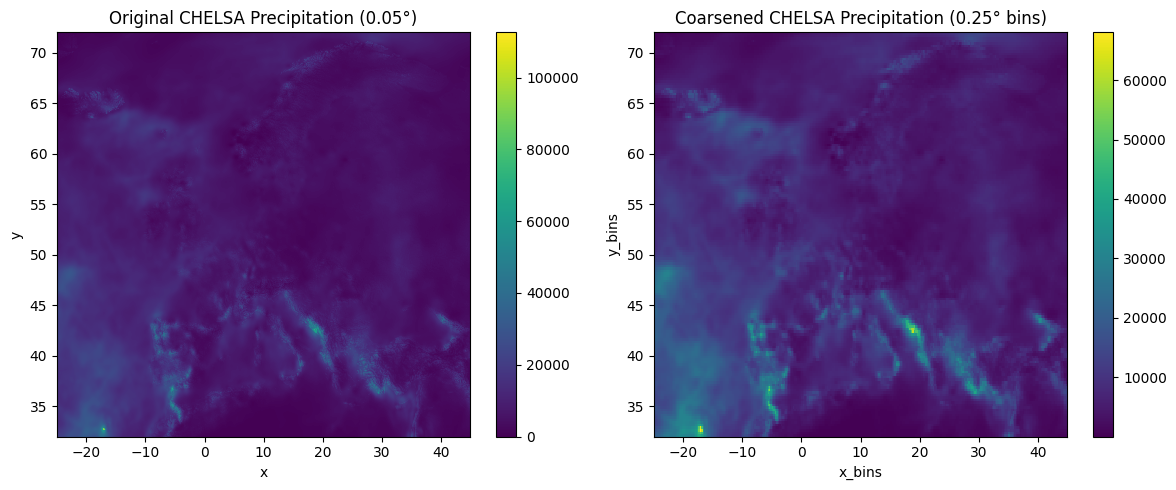

In [6]:
# Spatial crop before plotting
pr_roi = pr_xr.sel(
    y=slice(LAT_END, LAT_START),  # descending order for latitude
    x=slice(LON_START, LON_END)
)
# Plot original CHELSA precipitation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
pr_roi.plot(cmap="viridis")
plt.title("Original CHELSA Precipitation (0.05°)")

# Plot grouped (coarsened) precipitation
plt.subplot(1, 2, 2)
pr_xr_coarse.plot(cmap="viridis")
plt.title("Coarsened CHELSA Precipitation (0.25° bins)")

plt.tight_layout()
plt.show()

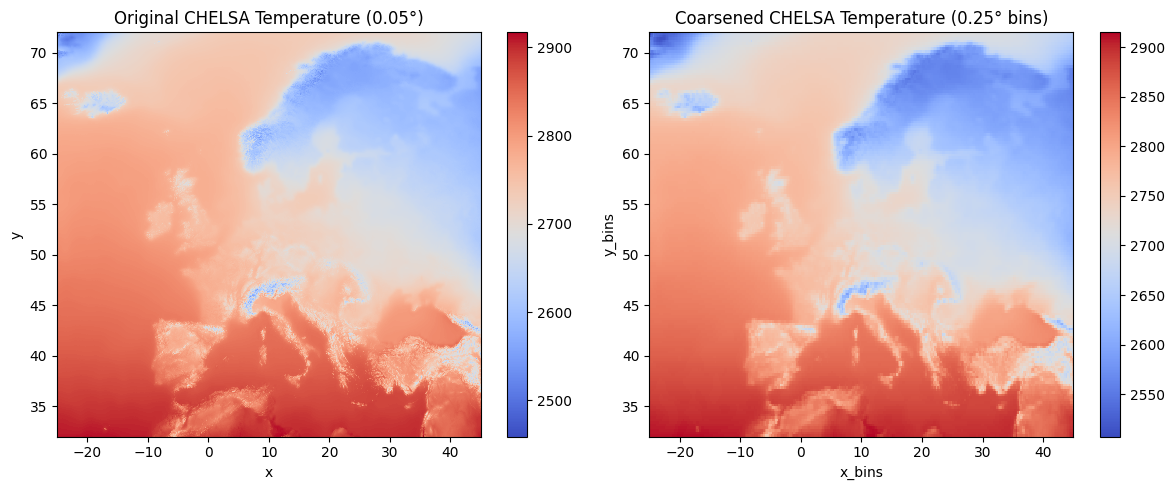

: 

In [ ]:
# Spatial crop before plotting
tas_roi = tas_xr.sel(
    y=slice(LAT_END, LAT_START),  # descending order for latitude
    x=slice(LON_START, LON_END)
)

# Plot original CHELSA temperature
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
tas_roi.plot(cmap="coolwarm")
plt.title("Original CHELSA Temperature (0.05°)")

# Plot grouped (coarsened) temperature
plt.subplot(1, 2, 2)
tas_xr_coarse.plot(cmap="coolwarm")
plt.title("Coarsened CHELSA Temperature (0.25° bins)")

plt.tight_layout()
plt.show()

### Plotting final datasets

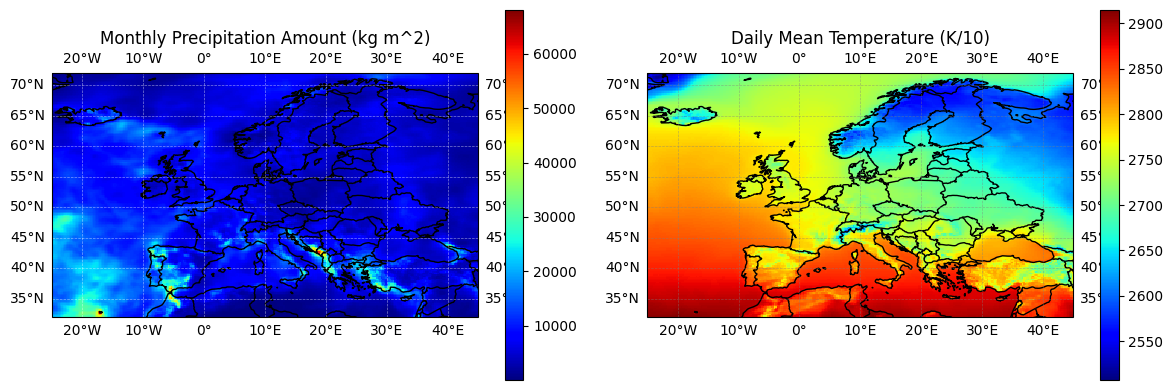

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#pr_xr_coarse = pr_xr_coarse.rename({'x_bins': 'lon', 'y_bins': 'lat'})
fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Precipitation plot
pr_xr_coarse.plot(ax=axes[0], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[0].set_title("Monthly Precipitation Amount (kg m^2)")
axes[0].add_feature(cfeature.BORDERS, linewidth=1)
axes[0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0].gridlines(draw_labels=True, linewidth=0.5, color='white', alpha=0.5, linestyle='--')

# Temperature plot
tas_xr_coarse.plot(ax=axes[1], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[1].set_title("Daily Mean Temperature (K/10)")
axes[1].add_feature(cfeature.BORDERS, linewidth=1)
axes[1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

### Read the Batch NetCDF4 file

In [8]:
ds = xr.open_dataset("/gpfs/work1/0/prjs1134/data/projects/biodt/storage/finetune/chelsa/chelsa_bfm_latents_downsampled.nc")
print(ds)

<xarray.Dataset> Size: 31GB
Dimensions:          (time: 234, pixel: 64400, embedding_dim: 256,
                      target_pixel: 44800, variable: 2)
Coordinates:
  * time             (time) datetime64[ns] 2kB 2000-01-01 ... 2019-06-01
  * embedding_dim    (embedding_dim) int64 2kB 0 1 2 3 4 ... 251 252 253 254 255
  * pixel            (pixel) int64 515kB 0 1 2 3 4 ... 64396 64397 64398 64399
  * variable         (variable) <U3 24B 'tas' 'pr'
Dimensions without coordinates: target_pixel
Data variables:
    encoder_output   (time, pixel, embedding_dim) float32 15GB ...
    backbone_output  (time, pixel, embedding_dim) float32 15GB ...
    target           (time, target_pixel, variable) float64 168MB ...
    decoder_input    (time, target_pixel, variable) float32 84MB ...


In [9]:
ds

<xarray.Dataset> Size: 31GB
Dimensions:          (time: 234, pixel: 64400, embedding_dim: 256,
                      target_pixel: 44800, variable: 2)
Coordinates:
  * time             (time) datetime64[ns] 2kB 2000-01-01 ... 2019-06-01
  * embedding_dim    (embedding_dim) int64 2kB 0 1 2 3 4 ... 251 252 253 254 255
  * pixel            (pixel) int64 515kB 0 1 2 3 4 ... 64396 64397 64398 64399
  * variable         (variable) <U3 24B 'tas' 'pr'
Dimensions without coordinates: target_pixel
Data variables:
    encoder_output   (time, pixel, embedding_dim) float32 15GB ...
    backbone_output  (time, pixel, embedding_dim) float32 15GB ...
    target           (time, target_pixel, variable) float64 168MB ...
    decoder_input    (time, target_pixel, variable) float32 84MB ...

In [11]:
# Select a single timestep (e.g., the first one)
t_idx = 220

# Extract variables for plotting
# The number of grid cells in GRID_LAT and GRID_LON is 161 and 281, but ds['target'] has 44800 pixels per timestep.
# Let's check the correct shape for reshaping:
expected_shape = (len(GRID_LAT) - 1, len(GRID_LON) - 1)  # 160 x 280

target_tas = ds['target'][t_idx, :, 0].values.reshape(expected_shape)
target_pr = ds['target'][t_idx, :, 1].values.reshape(expected_shape)

# Normalize the target data
target_tas = (target_tas - target_tas.min()) / (target_tas.max() - target_tas.min())
target_pr = (target_pr - target_pr.min()) / (target_pr.max() - target_pr.min())



input_tas = ds['decoder_input'][t_idx, :, 0].values.reshape(expected_shape)
input_pr = ds['decoder_input'][t_idx, :, 1].values.reshape(expected_shape)



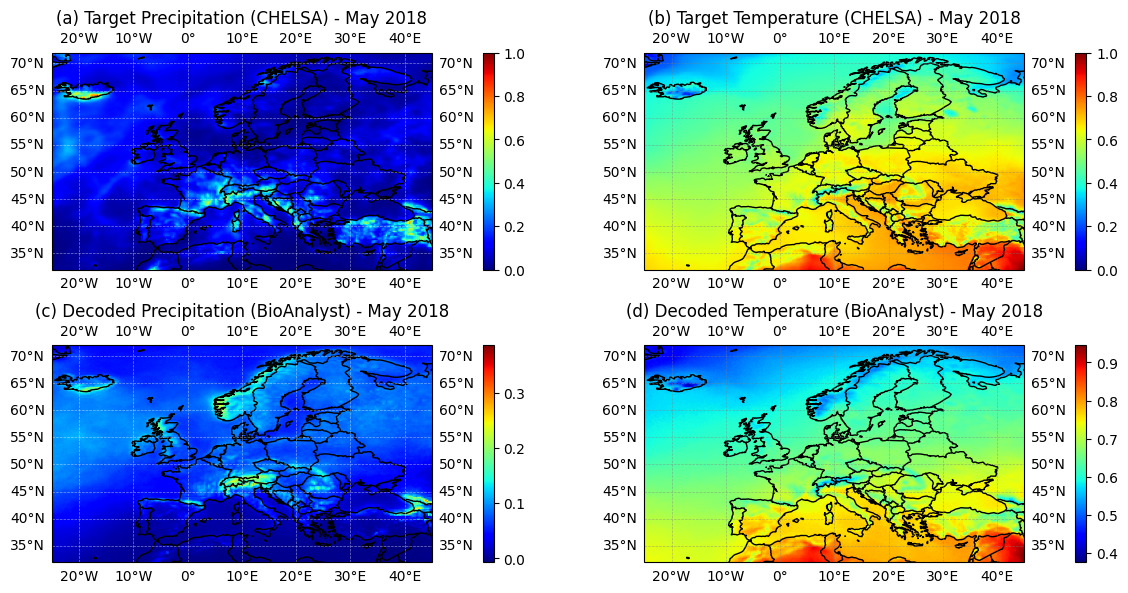

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Target Precipitation
im0 = axes[0, 0].imshow(target_pr, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap="jet")
axes[0, 0].set_title(f"(a) Target Precipitation (CHELSA) - {ds['target'].coords['time'][t_idx].dt.strftime('%b %Y').values}")
axes[0, 0].add_feature(cfeature.BORDERS, linewidth=1)
axes[0, 0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0, 0].gridlines(draw_labels=True, linewidth=0.5, color='white', alpha=0.5, linestyle='--')
cbar0 = plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.1)

# Target Temperature
im1 = axes[0, 1].imshow(target_tas, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap="jet")
axes[0, 1].set_title(f"(b) Target Temperature (CHELSA) - {ds['target'].coords['time'][t_idx].dt.strftime('%b %Y').values}")
axes[0, 1].add_feature(cfeature.BORDERS, linewidth=1)
axes[0, 1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0, 1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
cbar1 = plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.1)

# Decoded Precipitation
im2 = axes[1, 0].imshow(input_pr, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap="jet")
axes[1, 0].set_title(f"(c) Decoded Precipitation (BioAnalyst) - {ds['decoder_input'].coords['time'][t_idx].dt.strftime('%b %Y').values}")
axes[1, 0].add_feature(cfeature.BORDERS, linewidth=1)
axes[1, 0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1, 0].gridlines(draw_labels=True, linewidth=0.5, color='white', alpha=0.5, linestyle='--')
cbar2 = plt.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.1)

# Decoded Temperature
im3 = axes[1, 1].imshow(input_tas, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap="jet")
axes[1, 1].set_title(f"(d) Decoded Temperature (BioAnalyst) - {ds['decoder_input'].coords['time'][t_idx].dt.strftime('%b %Y').values}")
axes[1, 1].add_feature(cfeature.BORDERS, linewidth=1)
axes[1, 1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1, 1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
cbar3 = plt.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.1)

for ax in axes.flat:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

fig.savefig("/home/tkhan/bfm-finetune/outputs/chelsa_bioanalyst_comparison.png", dpi=300, bbox_inches='tight')

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget for selecting embedding dimension
embedding_dim_selector = widgets.Dropdown(
    options=[(f"Dim {i}", i) for i in range(256)],
    value=0,
    description='Embedding Dim:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

output = widgets.Output()

def plot_embedding(change):
    with output:
        clear_output(wait=True)
        dim = change['new']
        # Encoder embedding
        enc_emb = ds['encoder_output'][t_idx, :, dim].values.reshape(161, 400)
        # Backbone embedding
        back_emb = ds['backbone_output'][t_idx, :, dim].values.reshape(161, 400)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        im0 = axes[0].imshow(enc_emb, origin='lower', cmap='viridis')
        axes[0].set_title(f'Encoder Output, Embedding Dim {dim}')
        plt.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(back_emb, origin='lower', cmap='viridis')
        axes[1].set_title(f'Backbone Output, Embedding Dim {dim}')
        plt.colorbar(im1, ax=axes[1])
        for ax in axes:
            ax.set_xlabel('Pixel X')
            ax.set_ylabel('Pixel Y')
        plt.tight_layout()
        plt.show()

embedding_dim_selector.observe(plot_embedding, names='value')

display(embedding_dim_selector, output)
plot_embedding({'new': embedding_dim_selector.value})

Dropdown(description='Embedding Dim:', layout=Layout(width='300px'), options=(('Dim 0', 0), ('Dim 1', 1), ('Di…

Output()

In [ ]:
for i in range(3):  # visualize first 3 embeddings
    emb_i = ds['encoder_output'][t_idx, :, i].values.reshape(161, 400)
    plt.figure()
    plt.imshow(emb_i, origin='lower', cmap='viridis')
    plt.title(f"Encoder Output, Embedding Dim {i}")
    plt.colorbar()
    plt.show()

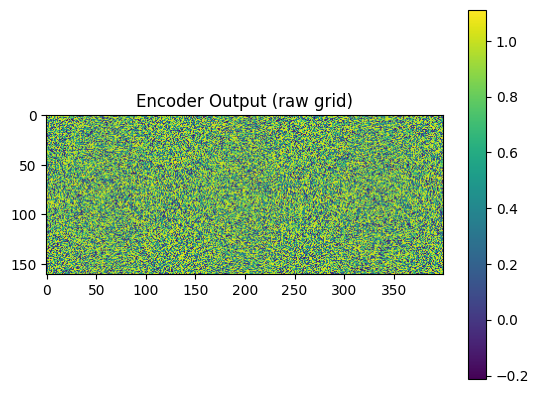

In [8]:
encoder_output = ds['encoder_output'][t_idx].mean(dim='embedding_dim').values.reshape(161, 400)
plt.imshow(encoder_output, cmap="viridis")
plt.title("Encoder Output (raw grid)")
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'PCA of encoder latents')

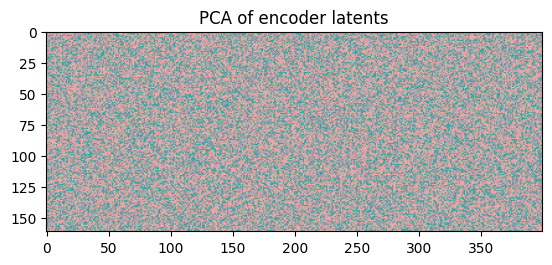

In [9]:
from sklearn.decomposition import PCA

latent = ds['encoder_output'][t_idx].values  # (pixel, 256)
pca = PCA(n_components=3)
reduced = pca.fit_transform(latent)  # (pixel, 3)

rgb = (reduced - reduced.min()) / (reduced.max() - reduced.min())
rgb = rgb.reshape(161, 400, 3)  # or whatever fits

plt.imshow(rgb)
plt.title("PCA of encoder latents")

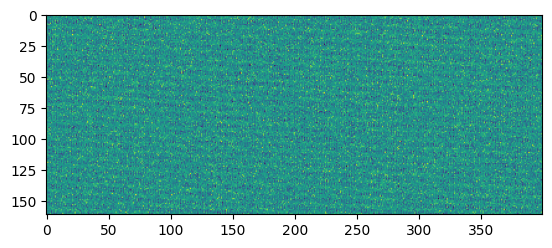

In [10]:
plt.imshow(ds['backbone_output'][t_idx].mean(dim='embedding_dim').values.reshape(161, 400), cmap='viridis')

In [11]:
from skimage.measure import shannon_entropy
entropy = shannon_entropy(encoder_output)  # lower entropy = more structured

In [12]:
entropy

np.float64(15.967494265288375)

In [14]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

X = ds['encoder_output'][t_idx].values  # (pixels, dim)
pca = PCA(n_components=5).fit_transform(X)  # (pixels, 5)

tas = ds['target'][t_idx, :, 0].values
pr = ds['target'][t_idx, :, 1].values
pca_reduced = pca[:44800]  # Truncate to match target pixels
for i in range(5):
    print(f"PC{i+1}–tas corr: {pearsonr(pca_reduced[:, i], tas)[0]:.3f}, PC{i+1}–pr corr: {pearsonr(pca_reduced[:, i], pr)[0]:.3f}")

PC1–tas corr: -0.002, PC1–pr corr: 0.003
PC2–tas corr: -0.001, PC2–pr corr: 0.010
PC3–tas corr: -0.003, PC3–pr corr: 0.001
PC4–tas corr: -0.001, PC4–pr corr: -0.001
PC5–tas corr: 0.001, PC5–pr corr: -0.001


In [ ]:
X = norm_input_tas.flatten()[:, None]  # shape: (44800, 1)
y = ds['target'][t_idx, :, 0].values   # tas (shape: 44800,)

from sklearn.linear_model import Ridge
ridge = Ridge().fit(X, y)
r2 = ridge.score(X, y)
print(f"R² score for tas: {r2:.4f}")

R² score for tas: 0.0056


In [24]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

input_tas = ds['decoder_input'][:, :, 0].values
input_pr = ds['decoder_input'][:, :, 1].values

target_tas = ds['target'][:, :, 0].values  
target_pr = ds['target'][:, :, 1].values


# Reshape to (timesteps, -1) for regression
X = input_tas.reshape(input_tas.shape[0], -1)
y = target_tas.reshape(target_tas.shape[0], -1)

ridge = Ridge()
ridge.fit(X, y)
y_pred = ridge.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² score for tas time series regression: {r2:.4f}")


R² score for tas time series regression: 0.7630


In [25]:
# Ridge regression for precipitation (pr) time series
X_pr = input_pr.reshape(input_pr.shape[0], -1)
y_pr = target_pr.reshape(target_pr.shape[0], -1)

ridge_pr = Ridge()
ridge_pr.fit(X_pr, y_pr)
y_pred_pr = ridge_pr.predict(X_pr)
r2_pr = r2_score(y_pr, y_pred_pr)
print(f"R² score for pr time series regression: {r2_pr:.4f}")

R² score for pr time series regression: 0.3228


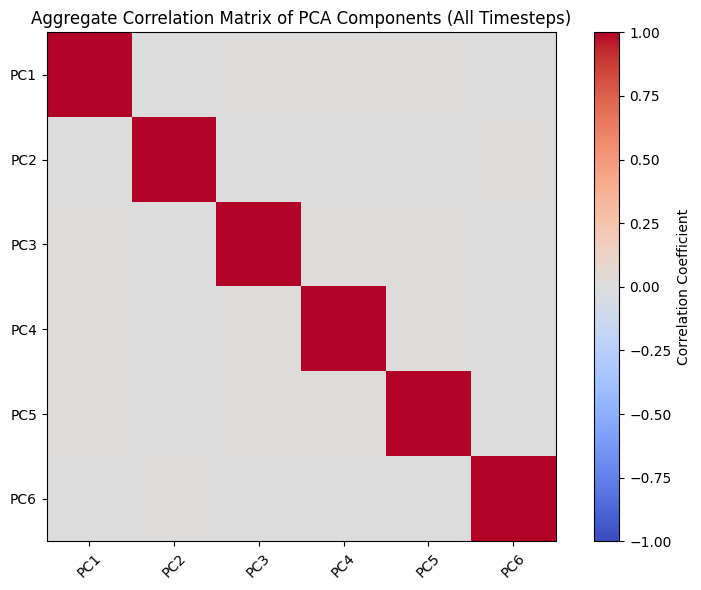

In [ ]:
from sklearn.decomposition import PCA

# Do a PCA on the backbone_output for all timesteps and aggregate the correlation matrices

n_components = 6
n_times = ds['backbone_output'].shape[0]
corr_matrices = []

for t in range(n_times):
    backbone_output = ds['backbone_output'][t].values  # (pixels, 256)
    pca_backbone = PCA(n_components=n_components)
    pca_backbone_components = pca_backbone.fit_transform(backbone_output)
    corr_matrix = np.corrcoef(pca_backbone_components.T)
    corr_matrices.append(corr_matrix)

# Aggregate: mean correlation matrix across all timesteps
agg_corr_matrix = np.mean(corr_matrices, axis=0)

# Plot the aggregate correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(agg_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(n_components), labels=[f'PC{i+1}' for i in range(n_components)], rotation=45)
plt.yticks(ticks=np.arange(n_components), labels=[f'PC{i+1}' for i in range(n_components)])
#plt.title('Aggregate Correlation Matrix of PCA Components (All Timesteps)')
plt.tight_layout()
plt.show()

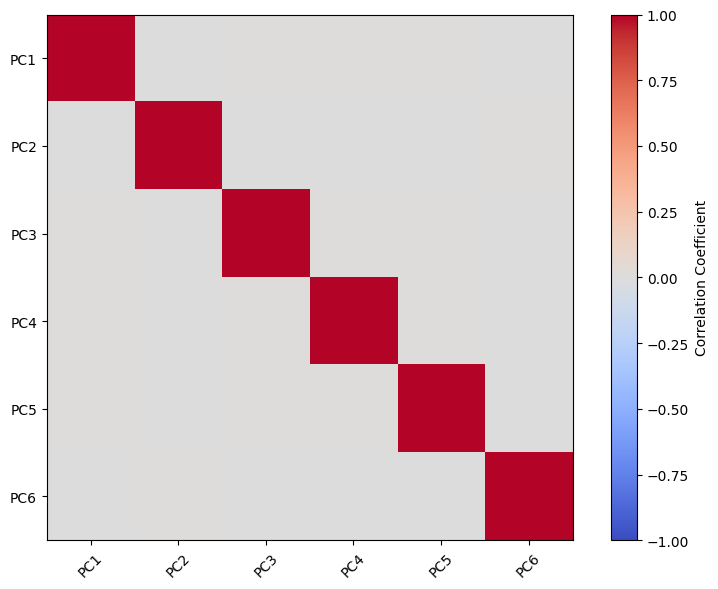

In [57]:
# Plot the aggregate correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(agg_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(n_components), labels=[f'PC{i+1}' for i in range(n_components)], rotation=45)
plt.yticks(ticks=np.arange(n_components), labels=[f'PC{i+1}' for i in range(n_components)])
#plt.title('Aggregate Correlation Matrix of PCA Components (All Timesteps)')
plt.tight_layout()
plt.show()

In [58]:
savedir = "/home/tkhan/bfm-finetune/outputs/chelsa_bioanalyst_PCA.png"

# save the plot in 300 dpi
plt.savefig(savedir, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>